In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import re
import plotly.graph_objs as go
import random

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import trange, tqdm
import pymorphy3
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def clean_html(text):
    if pd.isna(text):
        return np.nan
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    cleaned_text = cleaned_text.replace("\r", " ").replace("\n", " ")
    cleaned_text = re.sub(r"\s+", " ", cleaned_text)
    return cleaned_text.strip()

hh_vacancy = pd.read_csv('datasets/hhparser_vacancy.csv')
hh_vacancy["description"] = hh_vacancy["description"].apply(clean_html) 
vacancy_texts = hh_vacancy.apply(lambda row: f"{row['name']}\n{row['description']}", axis=1).tolist()

c:\Users\vanos\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [3]:
fields = [
    'Ищет работу на должность:',
    'Город, переезд, командировки',
    'Занятость',
    'Последнее/нынешнее место работы',
    'Последняя/нынешняя должность',
    'Образование и ВУЗ'
]

def create_job_text(row):
    parts = []
    for name in fields:
        parts.append(f"{name} {row[name]}")
    return "; ".join(parts)

hh_cv = pd.read_csv('datasets/dst-3.0_16_1_hh_database.csv', sep=';')
cv_texts = hh_cv.apply(create_job_text, axis=1).tolist()

In [12]:
def preprocess(text):
    pattern = re.compile("[^а-яА-Яa-zA-Z0-9\-.,;]+")
    sw = stopwords.words("russian")
    morph = pymorphy3.MorphAnalyzer()
    text = text.lower()
    text = pattern.sub(" ", text)
    tokens = simple_preprocess(text, deacc=True)
    tokens = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if token not in sw and len(token) > 2
    ]
    return tokens

In [6]:
tokenized_vacancy_texts = [preprocess(text) for text in vacancy_texts]
tokenized_cv_texts = [preprocess(text) for text in cv_texts]
train_corpus = tokenized_vacancy_texts + tokenized_cv_texts

with open('job_descriptions_list.pkl', 'rb') as f:
    job_descriptions_list = pickle.load(f)
job_descriptions_list = [clean_html(doc) for doc in job_descriptions_list]
with open('resume_descriptions_list.pkl', 'rb') as f:
    resume_descriptions_list = pickle.load(f)

labels = [[i] * 10 for i in range(10)]
labels = list(np.array(labels).flatten())

def precision(get_vector, desc, items, items_embs, labels, item_label):
    desc_emb = get_vector(desc)
    similarities = cosine_similarity([desc_emb], items_embs)[0]
    ranked_items = [(item, similarity, l) for item, similarity, l in zip(items, similarities, labels)]
    ranked_items.sort(key=lambda x: x[1], reverse=True)
    ranked_labels = np.array([x[2] for x in ranked_items])
    return (ranked_labels == item_label)

def avg_precision(get_vector, n_top=np.arange(1, 11)):
    items_embs = [get_vector(item) for item in resume_descriptions_list]
    precisions = {i:[] for i in n_top}
    for i in trange(100):
        ts = precision(get_vector, job_descriptions_list[i], resume_descriptions_list, items_embs, labels, i // 10)
        for k in n_top:
            precisions[k] += [ts[:k].sum() / k]
    return {k: sum(p) / 100 for k, p in precisions.items()}

In [ ]:
from gensim.models import Word2Vec

w2v = Word2Vec(sentences=train_corpus, vector_size=30, window=5, min_count=1, workers=4)

def get_w2v_vector(text):
    words = preprocess(text)
    word_vectors = [w2v.wv[word] for word in words if word in w2v.wv]
    if not word_vectors:
        return np.zeros(w2v.vector_size)
    return np.mean(word_vectors, axis=0)

w2v_precision = avg_precision(get_w2v_vector)

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

train_tagged = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(train_corpus)]

d2v = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
d2v.build_vocab(train_tagged)
d2v.train(train_tagged, total_examples=d2v.corpus_count, epochs=d2v.epochs)


def get_d2v_vector(text):
    doc = preprocess(text)
    return d2v.infer_vector(doc)

d2v_precision = avg_precision(get_d2v_vector)

In [78]:
from transformers import GPT2Model, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/rugpt3small_based_on_gpt2')
model = GPT2Model.from_pretrained('ai-forever/rugpt3small_based_on_gpt2')

def get_gpt2_vector(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(axis=1).squeeze(0).detach().numpy()

gpt2_precision = avg_precision(get_gpt2_vector)

100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


Text(0, 0.5, 'map@k')

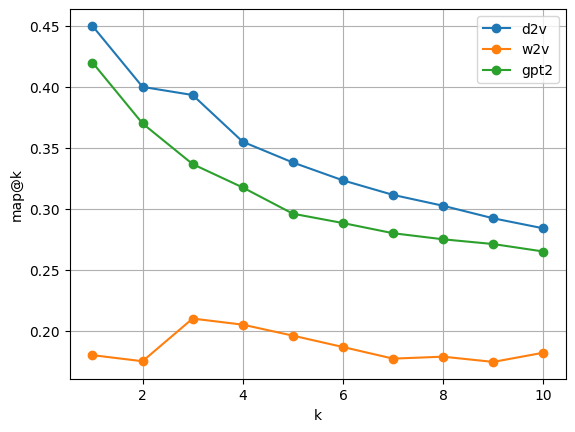

In [91]:
ax = pd.DataFrame({'d2v': d2v_precision, 'w2v': w2v_precision, 'gpt2': gpt2_precision}).plot(marker='o', grid=True)
ax.set_xlabel('k')
ax.set_ylabel('map@k')

In [90]:
cv_sample = random.sample(cv_texts, 1000)
embs = [get_d2v_vector(item) for item in tqdm(cv_sample)]

with open('d2v.pkl', 'wb') as f:
    pickle.dump(d2v, f)

with open('cv_sample.pkl', 'wb') as f:
    pickle.dump(cv_sample, f)

with open('embs.pkl', 'wb') as f:
    pickle.dump(embs, f)

100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]
